# DDQN Lunar Lander
Implementation of Double Deep Q-Network (DDQN) to solve the game Lunar Lander by earning more than +200 total reward on average over 100 trials.

In [1]:
#! /usr/bin/env python
# __author__ = 'Ning Shi'
# __email__ = 'MrShininnnnn@gmail.com'

In [2]:
# import dependency
import gym
from gym import wrappers

import os
import random
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
%matplotlib inline
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# path
CURR_PATH = os.path.abspath('')
OUTPUT_PATH = os.path.join(CURR_PATH, 'output')
RANDOM_AGENT_PATH = os.path.join(OUTPUT_PATH, 'random_agent')
DDQN_AGENT_PATH = os.path.join(OUTPUT_PATH, 'ddqn_agent')
DDQN_CHECKPOINT_PATH = os.path.join(DDQN_AGENT_PATH, 'policy_model_checkpoint.pth')
DDQN_RESULT_IMG_PATH = os.path.join(DDQN_AGENT_PATH, 'result_img_{}.png')

for p in [RANDOM_AGENT_PATH, DDQN_AGENT_PATH]:
    if not os.path.exists(p): 
        os.makedirs(p)

## Lunar Lander

![Lunar Lander](res/LunarLander.gif)
<center>(https://gym.openai.com/envs/LunarLander-v2/)</center>

Lunar Lander of OpenAI Gym is the game we want to solve in this work (Brockman et al. 2016). It is an interactive environment for an agent to land a rocket on a planet. A state here can be represented by an 8-dimensional continuous space:
$$ (x, y, v_{x}, v_{y}, v_{\theta}, leg_{left}, leg_{right}) $$
, where $x$ and $y$ are the coordinates of the lander's position; $v_{x}$ and $v_{y}$ are the velocity components on two axes; $\theta$ and $v_{\theta}$ are the angle and the angular velocity separately; $leg_{left}$ and $leg_{right}$ are two binary values standing for whether the left or right leg of the lander is touching the ground.

For each time step, there are four discrete actions available, that is, doing nothing, firing the left orientation engine, firing the main engine, and firing the right orientation engine.

The game will be over or passed if the lander crashes or comes to rest. The reward for a bad ending is -100, while that for a happy ending is +100. The touching of the leg to the ground can generate a +10 reward, but each time of firing the main engine incurs a -0.3 penalty. Therefore, the total reward for a single episode ranges from 100 to more than 200 based on the final location of the lander on the pad. The distance between the landing pad and the lander will cause a penalization, which equals to the reward gained by moving closer to the pad. 

A method will be treated as a successful solution for this game if it can achieve more than +200 points average over 100 consecutive episodes.

Note:
1. six dimensional continuous state space with two more discrete variables
2. discrete action space
3. landing pad at coordinates $(0, 0)$

In [4]:
env = gym.make('LunarLander-v2')
n_states, n_actions = env.observation_space.shape[0], env.action_space.n
print('state space: {}'.format(n_states))
print('action space: {}'.format(n_actions))

state space: 8
action space: 4


## Random Strategy

In [5]:
# take a look at how a random agent act in the game
# On OS X, you can install ffmpeg via `brew install ffmpeg`. 
# On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. 
# On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

class RandomAgent(object):
    """The world's simplest agent!"""
    def __init__(self, action_space):
        self.action_space = action_space

    def act(self):
        return self.action_space.sample()

env = wrappers.Monitor(env, RANDOM_AGENT_PATH, force=True)
agent = RandomAgent(env.action_space)
ob = env.reset()
while True:
    action = agent.act()
    _, _, done, _ = env.step(action)
    if done:
        break
env.close()

# find video record under ./output/random_agent

## Double Deep Q-Network

### Model Graph

In [5]:
class DDQN_Graph(nn.Module): 
    """
    Deep Reinforcement Learning with Double Q-Learning by Hasselt et al. (2016)
    Double Deep Q-Network Model Graph
    The neural network is a function from state space $R^{n_states}$ to action space $R^{n_actions}$
    
    """ 
    def __init__(self, n_states, n_actions, hidden_size=32): 
        super(DDQN_Graph, self).__init__()
        self.n_actions = n_actions
        self.half_hidden_size = int(hidden_size/2)
        # hidden representation
        self.dense_layer_1 = nn.Linear(n_states, hidden_size)
        self.dense_layer_2 = nn.Linear(hidden_size, hidden_size)
        # V(s)
        self.v_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.v_layer_2 = nn.Linear(self.half_hidden_size, 1)
        # A(s, a)
        self.a_layer_1 = nn.Linear(hidden_size, self.half_hidden_size)
        self.a_layer_2 = nn.Linear(self.half_hidden_size, n_actions)
        
    
    def forward(self, state):
        # state: batch_size, state_size
        # x: batch_size, hidden_size
        x = F.relu(self.dense_layer_1(state))
        # x: batch_size, hidden_size
        x = F.relu(self.dense_layer_2(x))
        # v: batch_size, half_hidden_size
        v = F.relu(self.v_layer_1(x))
        # v: batch_size, 1
        v = self.v_layer_2(v)
        # a: batch_size, half_hidden_size
        a = F.relu(self.a_layer_1(x))
        # a: batch_size, action_size
        a = self.a_layer_2(a)
        
        # Q(s,a) = V(s) + (A(s,a) - 1/|A| * sum A(s,a'))
        # batch_size, action_size
        return v + a - a.mean(dim=-1, keepdim=True).expand(-1, self.n_actions)

### Replay Memory

In [6]:
class ReplayMemory(): 
    """
    Replay memory records previous observations for the agent to learn later
    by sampling from the memory randomly
    """
    def __init__(self, capacity): 
        super(ReplayMemory, self).__init__() 
        self.capacity = capacity
        # to avoid empty memory list to insert transitions
        self.memory = [None] * capacity
        self.position = 0
        self.Transition = namedtuple('Transition', 
                                     ('state', 'action', 'reward', 'next_state', 'done'))
    
    def size(self):
        return len(self.memory) - self.memory.count(None)
    
    def push(self, *args):
        # save a transition at a certain position of the memory
        self.memory[self.position] = self.Transition(*args)        
        # update position
        self.position = (self.position + 1) % self.capacity
    
    def pull(self):
        return [exp for exp in self.memory if exp is not None]
    
    def sample(self, batch_size):
        exps = random.sample(self.pull(), batch_size)
        states = torch.tensor(np.vstack([e.state for e in exps if e is not None])).float()
        actions = torch.tensor(np.vstack([e.action for e in exps if e is not None])).long()
        rewards = torch.tensor(np.vstack([e.reward for e in exps if e is not None])).float()
        next_states = torch.tensor(np.vstack([e.next_state for e in exps if e is not None])).float()
        dones = torch.tensor(np.vstack([e.done for e in exps if e is not None]).astype(np.uint8)).float()
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

### Agent

In [7]:
class DDQN_Agent(): 
    """docstring for ddqn_agent"""
    def __init__(self, n_states, n_actions, batch_size, hidden_size, memory_size, 
                 update_step, learning_rate, gamma, tau):
        super(DDQN_Agent, self).__init__()
        # state space dimension
        self.n_states = n_states
        # action space dimension
        self.n_actions = n_actions
        # configuration
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.update_step = update_step
        self.lr = learning_rate
        self.gamma = gamma
        self.tau = tau
        # check cpu or gpu
        self.setup_gpu()
        # initialize model graph
        self.setup_model()
        # initialize optimizer
        self.setup_opt()
        # enable Replay Memory
        self.memory = ReplayMemory(memory_size)
        # others
        self.prepare_train()
    
    def setup_gpu(self): 
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    def setup_model(self):
        self.policy_model = DDQN_Graph(
            self.n_states, 
            self.n_actions, 
            self.hidden_size).to(self.device)
        self.target_model = DDQN_Graph(
            self.n_states, 
            self.n_actions, 
            self.hidden_size).to(self.device)
    
    def setup_opt(self):
        self.opt = torch.optim.Adam(self.policy_model.parameters(), lr=self.lr)
    
    def prepare_train(self):
        self.steps = 0
    
    def act(self, state, epsilon):
        # take an action for a time step
        # state: 1, state_size
        state = torch.tensor(state).reshape(1, -1).to(self.device)
        # inference by policy model
        self.policy_model.eval()
        with torch.no_grad(): 
            # action_vs: 1, action_size
            action_vs = self.policy_model(state)
        self.policy_model.train()
        # return action: 1
        # epsilon greedy search
        if np.random.random() > epsilon:
            return np.argmax(action_vs.cpu().detach().numpy())
        else:
            return np.random.randint(self.n_actions)
    
    def step(self, s, a, r, s_, done):
        # add one observation to memory
        self.memory.push(s, a, r, s_, done)
        # update model for every certain steps
        self.steps = (self.steps + 1) % self.update_step
        if self.steps == 0 and self.memory.size() >= self.batch_size:
            exps = self.memory.sample(self.batch_size)
            self.learn(exps)
        else:
            pass
    
    def learn(self, exps, soft_copy=True):
        
        for item in exps:
            item.to(self.device)
        # states: batch_size, state_size
        # actions: batch_size, 1
        # rewards: batch_size, 1
        # next_states: batch_size, state_size
        # dones: batch_size, 1
        states, actions, rewards, next_states, dones = exps
        # target side
        _, next_idx = self.policy_model(next_states).detach().max(1)
        # action values: batch_size, action_size
        target_next_action_vs = self.target_model(next_states).detach().gather(1, next_idx.unsqueeze(1))
        # Q values: batch_size, 1
        # Q = reward + (gamma * Q[next state][next action]) for not done
        target_q_vs = rewards + (self.gamma * target_next_action_vs * (1 - dones))
        # policy side
        # Q values: batch_size, 1
        policy_q_vs = self.policy_model(states).gather(1, actions)
        # compute MSE loss
        loss = F.mse_loss(policy_q_vs, target_q_vs)
        # update policy network
        self.opt.zero_grad()
        loss.backward()
        # gradient clamping
        for p in self.policy_model.parameters(): 
            p.grad.data.clamp_(-1, 1)
        self.opt.step()
        if soft_copy:
            # update target network via soft copy with ratio tau
            # θ_target = τ*θ_local + (1 - τ)*θ_target
            for tp, lp in zip(self.target_model.parameters(), self.policy_model.parameters()):
                tp.data.copy_(self.tau*lp.data + (1.0-self.tau)*tp.data)
        else:
            # update target network via hard copy
            self.target_model.load_state_dict(self.policy_model.state_dict())
        

### Training

In [8]:
# initial definition
batch_size = 64
hidden_size = 64
memory_size = int(1e5)
update_step = 4
learning_rate = 5e-4
gamma = 0.99
tau = 1e-2

n_episodes = 1000
max_epsilon = 1.0
min_epsilon = 0.01
decay_rate = 0.004
rewards_window_size = 100

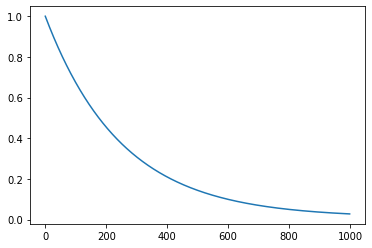

In [9]:
# initialize epsilon values for greedy search
epsilon_array = np.zeros((n_episodes))
for i in range(n_episodes):
    epsilon = min_epsilon + (max_epsilon-min_epsilon)*np.exp(-decay_rate*i)
    epsilon_array[i] = epsilon

plt.plot(epsilon_array)
plt.show()

In [11]:
# training process
# initialize the DDQN agent given a configuration
agent = DDQN_Agent(n_states, 
                   n_actions, 
                   batch_size, 
                   hidden_size, 
                   memory_size, 
                   update_step, 
                   learning_rate, 
                   gamma, 
                   tau)

def ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array):
    best_avg_rewards = 100.
    total_rewards = []
    rewards_deque = deque(maxlen=rewards_window_size)
    t = trange(n_episodes)
    for episode in t:
        # initialize the state
        cur_state = env.reset()
        done = False
        rewards = 0
        epsilon = epsilon_array[episode]
        while not done:
            action = agent.act(cur_state, epsilon)
            next_state, reward, done, _ = env.step(action)
            agent.step(cur_state, action, reward, next_state, done)
            cur_state = next_state
            rewards += reward
        # update information
        total_rewards.append(rewards)
        rewards_deque.append(rewards)
        avg_rewards = np.mean(rewards_deque)
        t.set_description(
            'Episode {} Epsilon {:.2f} Reward {:.2f} Avg_Reward {:.2f} Best_Avg_Reward {:.2f}'.format(
                episode + 1, epsilon, rewards, avg_rewards, best_avg_rewards))
        t.refresh()
        # evaluation
        if avg_rewards >= best_avg_rewards: 
            best_avg_rewards = avg_rewards
            torch.save(agent.policy_model.state_dict(), DDQN_CHECKPOINT_PATH)
        # the game is solved by earning more than +200 rewards for a single episode
        if best_avg_rewards > 200:
            break
    return total_rewards, rewards_deque

In [12]:
# a list of rewards for each episode
# and a deque of rewards for latest episode given a certain rewards window size
# training may take around 30 mins on CPU
train_rewards, train_rewards_deque = ddqn_learn_op(n_episodes, rewards_window_size, epsilon_array)

Episode 607 Epsilon 0.10 Reward 210.75 Avg_Reward 200.50 Best_Avg_Reward 198.62:  61%|██████    | 606/1000 [19:19<12:11,  1.86s/it]  

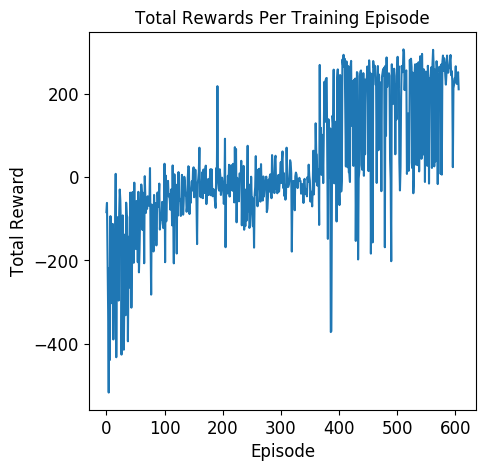

In [13]:
# show rewards change in training
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(train_rewards)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Episode', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Training Episode', fontsize=12)
plt.savefig(DDQN_RESULT_IMG_PATH.format(0), dpi=100, bbox_inches='tight')
plt.show()

### Evaluation

In [10]:
test_episodes=100
test_reward_array = np.zeros(100)
agent = DDQN_Agent(n_states, 
                   n_actions, 
                   batch_size, 
                   hidden_size, 
                   memory_size, 
                   update_step, 
                   learning_rate, 
                   gamma, 
                   tau)
# load check point to restore the model
agent.policy_model.load_state_dict(
    torch.load(DDQN_CHECKPOINT_PATH, map_location=agent.device))

t = trange(test_episodes, leave=True)
for episode in t: 
    state = env.reset()
    done = False
    rewards = 0. 
    while not done: 
        # disable epsilon greedy search
        action = agent.act(state, epsilon=0) 
        state, reward, done, _ = env.step(action)
        rewards += reward
    t.set_description('Episode {:.2f} Reward {:.2f}'.format(episode + 1, rewards))
    t.refresh()
    test_reward_array[episode] = rewards
env.close()

Episode 100.00 Reward 198.28: 100%|██████████| 100/100 [00:21<00:00,  4.63it/s]


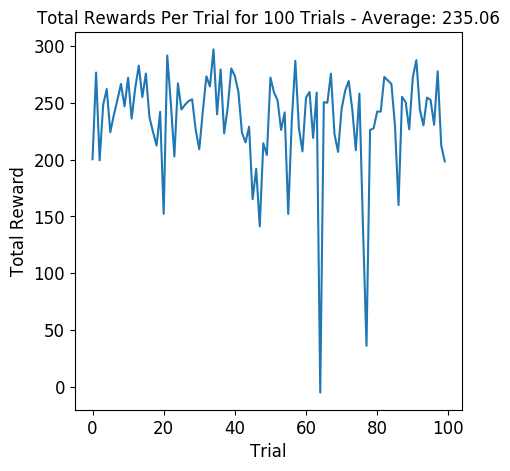

In [11]:
avg_test_reward = round(np.mean(test_reward_array), 2)
plt.subplots(figsize = (5, 5), dpi=100)
plt.plot(test_reward_array)
plt.ylabel('Total Reward', fontsize=12)
plt.xlabel('Trial', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Total Rewards Per Trial for 100 Trials - Average: {:.2f}'.format(avg_test_reward), 
          fontsize=12)
plt.savefig(DDQN_RESULT_IMG_PATH.format(1), dpi=100, bbox_inches='tight')
plt.show()

In [12]:
# take a look at how a DDQN agent act in the game
# On OS X, you can install ffmpeg via `brew install ffmpeg`. 
# On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. 
# On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.

env = wrappers.Monitor(env, DDQN_AGENT_PATH, force=True)
state = env.reset()
done = False
rewards = 0.
while True:
    # disable epsilon greedy search
    action = agent.act(state, epsilon=0)
    state, reward, done, _ = env.step(action)
    rewards += reward
    if done:
        print('Total Rewards in this game: {:.2f}'.format(rewards))
        break
env.close()

# find video record under ./output/ddqn_agent

Total Rewards in this game: 262.36


## Reference

1. Hasselt, H. V. (2010). Double Q-learning. In Advances in neural information processing systems (pp. 2613-2621).
2. Van Hasselt, H., Guez, A., & Silver, D. (2016, March). Deep reinforcement learning with double q-learning. In Thirtieth AAAI conference on artificial intelligence.
3. Brockman, G., Cheung, V., Pettersson, L., Schneider, J., Schulman, J., Tang, J., & Zaremba, W. (2016). Openai gym. arXiv preprint arXiv:1606.01540.